# 正規分布のベイズ分析

正規分布の確率密度関数$\mathcal{N}(\mu, \sigma^2)$は
$$
p(x|\mu, \sigma^2) = 
\frac{1}{\sqrt{2\pi \sigma^2}}
\exp\left[
    - \frac{(x-\mu)^2}{2\sigma^2}
\right]
$$

正規分布のパラメータ$\mu$, $\sigma^2$が以下のような事前分布に従うとする。
$$
\begin{align}
\mu|\sigma^2 &\sim \mathcal{N} \left(\mu_0, \frac{\sigma}{n_0} \right) \\
\sigma^2 &\sim \mathcal{G}a^{-1} \left( \frac{\nu_0}{2}, \frac{\lambda_0}{2}\right)
\end{align}
$$

$\mathcal{G}a^{-1}$は逆ガンマ分布と呼ばれ、その確率密度関数は、
$$
p(x|\alpha, \beta) = \frac{\beta^\alpha}{\Gamma(\alpha)} x^{-(\alpha+1)} \exp\left(- \frac{\beta}{x}\right)
$$

であらわされる。

まとめると、$\mu$, $\sigma^2$の事前分布は、
$$
\begin{align}
p(\mu, \sigma^2) &= p(\mu| \sigma^2) p(\sigma^2)
\\
p(\mu| \sigma^2) &= \sqrt{\frac{n_0}{2\sigma^2}} \exp\left[-\frac{n_0(\mu - \mu_0)^2}{2\sigma^2}\right]
\\
p(\sigma^2) &= \frac{(\lambda_0/2)^{\nu_0/2}}{\Gamma(\nu/2)} (\sigma^2)^{-\left( \frac{\nu_0}{2}+1 \right) } \exp\left( - \frac{\lambda_0}{2\sigma^2} \right)
\end{align}
$$

で与えられる。

また$p(\mu|\sigma^2)$を$\sigma^2$について積分すると、$\sigma^2$によらない$\mu$の周辺事前分布が得られる。$\mu$の周辺事前分布はt分布、
$$
\begin{align}
\mu &\sim \mathcal{T}(\nu_0, \mu_0, \tau_0^2) \\
\tau_0^2 &= \frac{\lambda_0}{\nu_0 n_0}
\end{align}
$$
となる。

ベイズの定理より、事前分布は
$$
\begin{align}
p&(\mu, \sigma^2|D) \\
&\propto p(D|\mu, \sigma) p(\mu|\sigma^2) p(\sigma^2) \\
&\propto (\sigma^2)^{-n/2} \exp \left[- \frac{\sum (x_i - \bar{x} )^2 + n( \bar{x} - \mu)^2}{2\sigma^2} \right]\\
&\ \ \ \ \times (\sigma^2)^{-1/2} \exp \left[ \frac{n_0(\mu-\mu_0)^2}{2\sigma^2} \right] \\
&\ \ \ \ \times (\sigma^2)^{-\left(\frac{\nu_0}{2}+1\right)} \exp \left[ - \frac{\lambda_0}{2\sigma^2} \right]
\end{align}
$$

これを整理すると、


$$
\begin{align}
p(\mu, \sigma^2|D) \propto
& (\sigma^2)^{-1/2} \exp \left[ - \frac{-n_* (\mu-\mu_*)^2}{2\sigma^2} \right] \\
&\times (\sigma^2)^{-\left(\frac{\nu_*}{2} + 1 \right)} \exp\left(-\frac{\lambda_*}{2\sigma^2}\right)
\end{align}
$$
ただし
$$
\begin{align}
\mu_* &= \frac{n \bar{x} + n_0 \mu_0}{n+n_0}\\
n_* &= n+n_0\\
\nu_* &= n + \nu_0\\
\lambda_* &= \sum_{i=1}^{n} (x_i - \bar{x})^2 + \frac{n n_0}{n + n_0} (\mu_0 - \bar{x})^2 + \lambda_0
\end{align}
$$
となる。

すなわち事後分布は、
$$
\begin{align}
\mu|\sigma^2 &\sim \mathcal{N} \left(\mu_*, \frac{\sigma}{n_*} \right) \\
\sigma^2 &\sim \mathcal{G}a^{-1} \left( \frac{\nu_*}{2}, \frac{\lambda_*}{2}\right)
\end{align}
$$
となる。

$p(\mu|\sigma^2)$を$\sigma^2$について積分すると、$\mu$の周辺事前分布が得られる。$\mu$の周辺事前分布はt分布、
$$
\begin{align}
\mu &\sim \mathcal{T}(\nu_*, \mu_*, \tau_*^2) \\
\tau_*^2 &= \frac{\lambda_*}{\nu_* n_*}
\end{align}
$$
となる。

In [1]:
import numpy as np
import scipy.stats as st
import scipy.optimize as opt
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
def invgamma_hpdi(ci0, alpha, beta, prob):
    """
    Input:
        ci0: initial value for HPD interval
        alpha, beta: pram for inv gamma function
        prob: probability of HPD interval
    Output:
        HPD interval
    """
    def hpdi_conditions(v, a, b, p):
        eq1 = st.invgamma.cdf(v[1], a, scale=b) - st.invgamma.cdf(v[0], a, scale=b) - p
        eq2 = st.invgamma.pdf(v[1], a, scale=b) - st.invgamma.pdf(v[0], a, scale=b)
        return np.hstack((eq1, eq2))
    return opt.root(hpdi_conditions, ci0, args=(alpha, beta, prob)).x
    
def gaussian_stats(data, mu0, n0, nu0, lam0, prob):
    n = data.size
    mean_data = data.mean()
    ssd_data = n * data.var()
    
    n_star = n + n0
    mu_star = (n * mean_data + n0*mu0)/n_star
    nu_star = n + nu0
    lam_star = ssd_data + n*n0/n_star * (mu0 - mean_data)**2 + lam0
    tau_star = np.sqrt(lam_star/nu_star/n_star)

    # posterior stats of mu
    mean_mu, median_mu, mode_mu = mu_star, mu_star, mu_star
    sd_mu = st.t.std(nu_star, loc=mu_star, scale=tau_star)
    ci_mu = st.t.interval(prob, nu_star, loc=mu_star, scale=tau_star)
    hpdi_mu = ci_mu
    
    # posterior stats of sigma2
    mean_sigma2 = st.invgamma.mean(0.5*nu_star, scale=0.5*lam_star)
    median_sigma2 = st.invgamma.median(0.5*nu_star, scale=0.5*lam_star)
    mode_sigma2 = lam_star / (nu_star + 2.0)
    sd_sigma2 = st.invgamma.std(0.5*nu_star, scale=0.5*lam_star)
    ci_sigma2 = st.invgamma.interval(prob, 0.5*nu_star, scale=0.5*lam_star)
    hpdi_sigma2 = invgamma_hpdi(ci_sigma2, 0.5*nu_star, 0.5*lam_star, prob)

    # stats
    stats_string = ['mean', 'median', 'mode', 'std', 'ci (lower)', 'ci (upper)', 'hpdi (lower)', 'hpdi (upper)']
    stats_mu = np.hstack((mean_mu, median_mu, mode_mu, sd_mu, ci_mu, hpdi_mu))
    stats_sigma2 = np.hstack((mean_sigma2, median_sigma2, mode_sigma2, sd_sigma2, ci_sigma2, hpdi_sigma2))
    stats = np.vstack((stats_mu, stats_sigma2))
    param_string = ['mu', 'sigma2']
    results = pd.DataFrame(stats, index=param_string, columns=stats_string)
    return results, mu_star, tau_star, nu_star, lam_star


## Generate data and calculate posterior

In [19]:
# Generate data
mu = 1.0
sigma = 2.0
n = 50
np.random.seed(99)
data = st.norm.rvs(loc=mu, scale=sigma, size=n)

# prior
mu0 = 0.0
n0 = 0.2
nu0 = 5.0
lam0 = 7.0
tau0 = np.sqrt(lam0/nu0/n0)
prob = 0.95

# calc posterior
results, mu_star, tau_star, nu_star, lam_star \
    = gaussian_stats(data, mu0, n0, nu0, lam0, prob)

# See results and plot

In [20]:
results

,mean,median,mode,std,ci (lower),ci (upper),hpdi (lower),hpdi (upper)
mu,1.004282,1.004282,1.004282,0.271394,0.470378,1.538187,0.470378,1.538187
sigma2,3.697454,3.606622,3.437984,0.732205,2.532488,5.383935,2.402354,5.165040


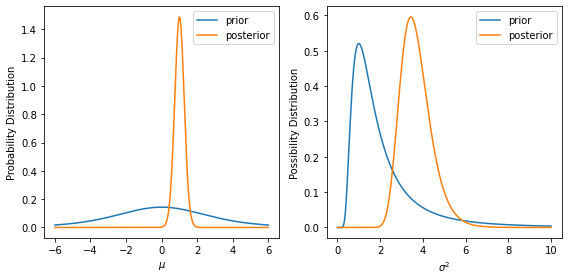

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(8,4))
x1 = np.linspace(-6, 6, 250)
ax[0].plot(x1, st.t.pdf(x1, nu0,     loc=mu0,     scale=tau0),     label='prior')
ax[0].plot(x1, st.t.pdf(x1, nu_star, loc=mu_star, scale=tau_star), label='posterior')
ax[0].set_xlabel(r'$\mu$')
ax[0].set_ylabel('Probability Distribution')
ax[0].legend()

x2 = np.linspace(0, 10, 250)
ax[1].plot(x2, st.invgamma.pdf(x2, 0.5*nu0,     scale=0.5*lam0),     label='prior')
ax[1].plot(x2, st.invgamma.pdf(x2, 0.5*nu_star, scale=0.5*lam_star), label='posterior')
ax[1].set_xlabel(r'$\sigma^2$')
ax[1].set_ylabel('Possibility Distribution')
ax[1].legend()

fig.tight_layout()
plt.show()